In [29]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras

# 1. Pfade
csv_path = r"Scenario A1-ARFF\NAB\artificialWithAnomaly\artificialWithAnomaly\art_increase_spike_density.csv"
json_path = r"Scenario A1-ARFF\NAB\artificialWithAnomaly\artificialWithAnomaly\combined_windows.json"
model_path = r"Scenario A1-ARFF\Scenario A1-ARFF\KerasAE"

# 2. Modell laden
model = keras.models.load_model(model_path)

# 3. CSV einlesen und vorbereiten
df = pd.read_csv(csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
data = df['value'].values.astype(np.float32)

# 4. Sequenzen erstellen
sequence_length = 288
X_seq = []
for i in range(len(data) - sequence_length):
    seq = data[i:i+sequence_length].reshape(-1, 1)  # (288, 1)
    X_seq.append(seq)
X_seq = np.array(X_seq)  # (n, 288, 1)
print("X_seq shape:", X_seq.shape)

# 5. Vorhersage und MSE berechnen
pred = model.predict(X_seq)
mse = np.mean((X_seq - pred)**2, axis=(1, 2))
print("Beispielhafte MSE:", mse[:10])

# 6. Threshold & Anomalien
threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)
print(f"Threshold (95%): {threshold:.6f}")
print(f"Anomalien erkannt: {np.sum(y_pred)} von {len(y_pred)}")

# 7. Ground Truth aus JSON laden
with open(json_path, 'r') as f:
    gt = json.load(f)
filename = os.path.basename(csv_path)
windows = gt["artificialWithAnomaly/" + filename]

# 8. Ground-Truth-Label erzeugen
timestamps = df.index[sequence_length:]
y_true = []
for ts in timestamps:
    is_anomaly = 0
    for start, end in windows:
        if pd.to_datetime(start) <= ts <= pd.to_datetime(end):
            is_anomaly = 1
            break
    y_true.append(is_anomaly)
y_true = np.array(y_true)

# 9. Evaluation 
print("\n CLASSIFICATION REPORTAGE:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))
print("CONFUSION MATRIX:")
print(confusion_matrix(y_true, y_pred))

# 10. Plot MSE mit Threshold
plt.figure(figsize=(14, 4))
plt.plot(timestamps, mse, label="MSE")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold (95%)")
plt.title("Rekonstruktionsfehler (MSE) über Zeit")
plt.xlabel("Zeit")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()


OSError: No file or directory found at Scenario A1-ARFF\Scenario A1-ARFF\KerasAE

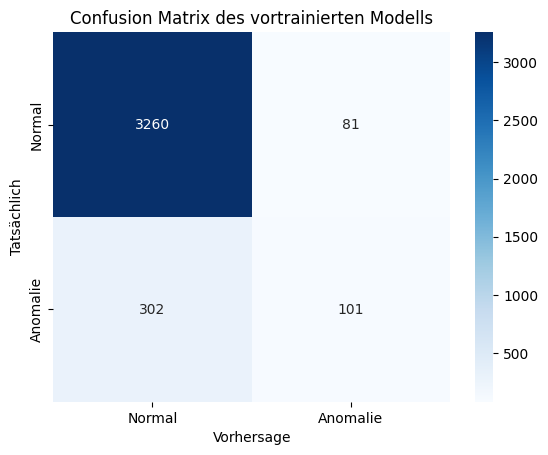

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = [[3260, 81], [302, 101]]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalie'], yticklabels=['Normal', 'Anomalie'])
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächlich')
plt.title('Confusion Matrix des vortrainierten Modells')
plt.show()


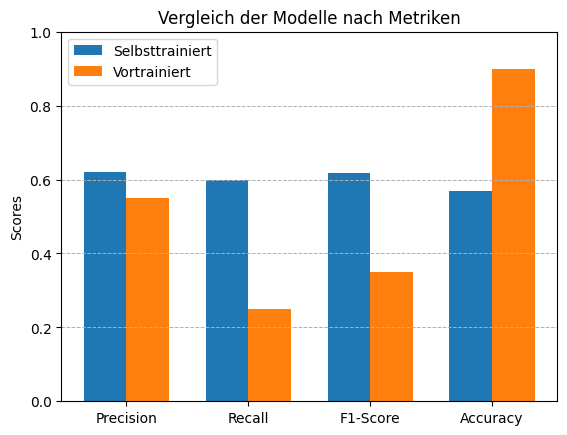

In [23]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
self_trained = [0.62, 0.60, 0.6188, 0.57]
pretrained = [0.55, 0.25, 0.35, 0.90]
x = np.arange(len(labels))

fig, ax = plt.subplots()
width = 0.35
rects1 = ax.bar(x - width/2, self_trained, width, label='Selbsttrainiert')
rects2 = ax.bar(x + width/2, pretrained, width, label='Vortrainiert')

ax.set_ylabel('Scores')
ax.set_title('Vergleich der Modelle nach Metriken')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()
